# Seasonal cycle in idealized GCM - wavenumber 3
- varying zonal wavenumbers
- for AGU 2021


- NB:
- lat and v are -ve so that same orientation as in ERA5
- ,ay want to increase ert levels to 20

In [12]:
#modules
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import integrate
import h5py as h5
from scipy import ndimage

# global parameters:
_a = 6371000.0
_g = 9.81 

In [13]:
def print_ncinfo(dataset):
    for var in dataset.variables:
        var1 = dataset.variables[var]
        for name in var1.ncattrs():
            print var, '-->',name, '=', getattr(var1,name)

def append_month_days(fn, mo_i, yr_i, hw, yr_list, ncinfo = False):
    """
    - extract momthly data from FMS daily output
    """
    print(fn)
    ncdata =Dataset(fn%(yr_list[yr_i], 1),'r')
    if ncinfo == True:
        print_ncinfo(ncdata)
    lat = ncdata.variables['lat'][:][::-1]
    lon = ncdata.variables['lon'][:]
    p = ncdata.variables['sigma'][:][:-2][::-1] * 1.0e5
    ncdata.close()
    U = np.zeros((30+hw*2, len(p), len(lat), len(lon)))
    V = np.zeros((30+hw*2, len(p), len(lat), len(lon)))
    T = np.zeros((30+hw*2, len(p), len(lat), len(lon)))
    Z = np.zeros((30+hw*2, len(p), len(lat), len(lon)))
    t = np.arange(mo_i*30-hw,(mo_i+1)*30+hw)
    
    for d_i, d in enumerate(t):
        if d < 0:
            ncdata = Dataset(fn%(yr_list[yr_i - 1], int(360. + d+1.0) ),'r')
        elif d > 359:
            ncdata = Dataset(fn%(yr_list[yr_i + 1], int(d+1.0 - 360.) ),'r')
        else:
            ncdata = Dataset(fn%(yr_list[yr_i], int(d+1.0) ),'r')
        U[d_i,:,:,:]=ncdata.variables['u'][:][:-2,:,:][::-1,::-1,:]
        V[d_i,:,:,:]=ncdata.variables['v'][:][:-2,:,:][::-1,::-1,:]
        T[d_i,:,:,:]=ncdata.variables['temp'][:][:-2,:,:][::-1,::-1,:]
        Z[d_i,:,:,:]=ncdata.variables['z'][:][:-2,:,:][::-1,::-1,:] 
        ncdata.close()
    return U, V, T, Z, p, lat, lon, t

In [14]:
def lat_of_maxval(F, la, n=6, axis=2):
    """
    TropD_Calculate_MaxLat
    # following Schneider et al 2006
    - note that this method performs poorly for multiple maxima
    """
    F = F - np.min(F) # Shift lowest value to 0
    F = F / np.max(F) # Scale F between [0 1]
    Ymax = integrate.trapz(F**n * la, la, axis = axis) / integrate.trapz(F**n, la, axis = axis) 
    return Ymax

# modified third party functions

import numpy as np
from scipy import signal
from datetime import date, timedelta


# Functions: 
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.
    
    Refs:
    - https://scitools.org.uk/iris/docs/v1.2/examples/graphics/SOI_filtering.html
    - Duchon C. E. (1979) Lanczos Filtering in One and Two Dimensions.
    Journal of Applied Meteorology, Vol 18, pp 1016-1022.

    """
    order = ((window - 1) / 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([int(nwts)])
    n = int(nwts / 2)
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]


def calc_transient_eddies(var, win_length, mean_only=False):
    """
    - calculate transient mean eddies using the Lanczos filter with a specified window length
    - avoids using iris
    """
    
    # setup Lanczos params
    window = win_length+1.0 # the wider the better (before get -ve weights)
    f = 1./win_length
    hw60 = int(win_length/2)
    wgts11 = low_pass_weights(window, f) 

    mean = np.apply_along_axis(lambda m: np.convolve(m, wgts11, mode='valid'), axis=0, arr=var)
    
    #print(np.shape(var))
    pert = var[hw60:-hw60,:,:,:] - mean
    if mean_only == True:
        return mean
    else:
        return mean, pert
        

In [32]:
# dirs / fnames
day_list = np.arange(1,361)
yr_list = np.array([2160, 2520, 2880, 3240]) # m=3: np.array([2160, 2520, 2880, 3240]) 
mo_list = np.arange(1,13,1)
print yr_list

depth_ocean_list = [6, 10, 40]
num_fourier_list = [3] #3,42

y = yr_list[0]
f = num_fourier_list[0]
o = depth_ocean_list[0]


data_dir = "/central/scratch/elencz/caltech_fms_idealized/slab_syn_diff/slab_syn_diff_num_fourier_%s_background_m_0.5_background_t_0.5_drag_min_100.e-05_depth_ocean_%s.0_qflux_amp_40.0/output/ppp_output/history/"
fname = "day%sh00.segment%s.nc"

var_save_dir = "/central/scratch/elencz/caltech_fms_idealized/slab_syn_diff/analysis/"

[2160 2520 2880 3240]


In [33]:
# Time filtering onfo
# specify window length for time filtering (e.g. high frequency eddy calculation)
win_length = 10.0
hw = int(win_length/2) # for eddy filtering we will use the edges of the timeseries so we'll need to factor in more data

win_length30 = 30.0
hw30 = int(win_length30/2) # for eddy filtering we will use the edges of the timeseries so we'll need to factor in more data

win_length60 = 60.0
hw60 = int(win_length60/2) # for eddy filtering we will use the edges of the timeseries so we'll need to factor in more data



In [34]:
p.data[1::-1]

array([83257.83312321, 95468.64628792])

/central/scratch/elencz/caltech_fms_idealized/slab_syn_diff/slab_syn_diff_num_fourier_3_background_m_0.5_background_t_0.5_drag_min_100.e-05_depth_ocean_10.0_qflux_amp_40.0/output/ppp_output/history//day%sh00.segment%s.nc
/central/scratch/elencz/caltech_fms_idealized/slab_syn_diff/slab_syn_diff_num_fourier_3_background_m_0.5_background_t_0.5_drag_min_100.e-05_depth_ocean_10.0_qflux_amp_40.0/output/ppp_output/history//day%sh00.segment%s.nc
/central/scratch/elencz/caltech_fms_idealized/slab_syn_diff/slab_syn_diff_num_fourier_3_background_m_0.5_background_t_0.5_drag_min_100.e-05_depth_ocean_10.0_qflux_amp_40.0/output/ppp_output/history//day%sh00.segment%s.nc
/central/scratch/elencz/caltech_fms_idealized/slab_syn_diff/slab_syn_diff_num_fourier_3_background_m_0.5_background_t_0.5_drag_min_100.e-05_depth_ocean_10.0_qflux_amp_40.0/output/ppp_output/history//day%sh00.segment%s.nc
/central/scratch/elencz/caltech_fms_idealized/slab_syn_diff/slab_syn_diff_num_fourier_3_background_m_0.5_background_

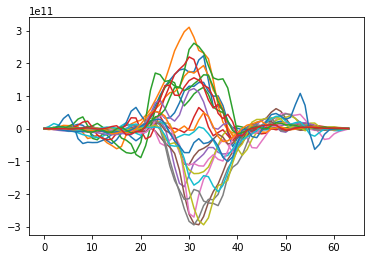

In [35]:

#lat, lon, sig, v, u = append_year_days((data_dir+'/'+fname)%('42', '6', '1800','%s')  )
m = num_fourier_list[0] # zonal wavenumber
fn = (data_dir+'/'+fname)%(str(m), '10', '%s','%s') 

for yr_i, yr in enumerate(yr_list):
    for mo_i, mo in enumerate(mo_list):
        if (yr_i == 0) or (yr_i ==len(yr_list)-1):
            break
        U, V, T, Z, p, lat, lon, t = append_month_days(fn, mo_i, yr_i, hw60, yr_list)# [30, p, la, lo]

        # preprocessing
        latrad = lat * np.pi / 180.
        nh_i = [np.where(lat > 0)][0][0]
        sh_i = [np.where(lat < 0)][0][0]

        # 0. Average fields

        ## zonal mean
        U_xBAR = np.mean(U,axis=-1) 
        V_xBAR = np.mean(V,axis=-1) 
        T_xBAR = np.mean(T,axis=-1) 

        ## northw60ard eddy fluxes
        ### zonal mean-based (stationary + transient)
        vSTTST = np.mean( (V - V_xBAR[:,:,:,None]) *(T - T_xBAR[:,:,:,None]) ,axis=-1)
        uSTvST = np.mean( (V - V_xBAR[:,:,:,None]) *(U - U_xBAR[:,:,:,None]) ,axis=-1) 
        vSTvST = np.mean( (V - V_xBAR[:,:,:,None]) *(V - V_xBAR[:,:,:,None]) ,axis=-1) 

        ### high-frequency transient only
        V_tBAR, vPR = calc_transient_eddies(V, win_length)
        U_tBAR, uPR = calc_transient_eddies(U, win_length)
        T_tBAR, TPR = calc_transient_eddies(T, win_length)

        ### high-frequency transient only
        V_tBAR30, vPR30 = calc_transient_eddies(V, win_length30)
        U_tBAR30, uPR30 = calc_transient_eddies(U, win_length30)
        T_tBAR30, TPR30 = calc_transient_eddies(T, win_length30)

        ### high-frequency transient only
        V_tBAR60, vPR60 = calc_transient_eddies(V, win_length60)
        U_tBAR60, uPR60 = calc_transient_eddies(U, win_length60)
        T_tBAR60, TPR60 = calc_transient_eddies(T, win_length60)    

        # 1. Hadley cell strength

        ## streamfunciton as vertical integral of v
        level_list_array = np.array([ 1000.,  3000.,  5000.,  10000.,  15000.,  20000.,  30000., 50000.,  80000., 90000.])[::-1] 
        #level_list_array = np.array([ 10000.,  20000.,  30000.,  40000.,  50000.,  60000.,  70000., 80000.,  90000., 100000.])[::-1] #p.data # XX
        #print(np.shape(integrate.cumtrapz(V_xBAR,level_list_array,axis = 1)))

        psi = _a/_g * 2. * np.pi * np.cos(latrad)[None,None,:] * integrate.cumtrapz(V_xBAR,level_list_array,axis = 1)

        sh_trop_i = [i for i,x in enumerate(lat) if ((x > -40) & (x < 0))]
        nh_trop_i = [i for i,x in enumerate(lat) if ((x > 0) & (x < 40))]

        ## HC center lats
        phi_HCmid_sh = lat_of_maxval(-psi[:,:,sh_trop_i], lat[None,None,sh_trop_i])
        phi_HCmid_nh = lat_of_maxval(psi[:,:,nh_trop_i],lat[None,None,nh_trop_i])
        max_HCmid_sh = np.max(-psi[:,:,sh_trop_i],axis = 2)
        max_HCmid_nh = np.max( psi[:,:,nh_trop_i],axis = 2)

        # 2. upwelling and downwelling HC branches (zero crossing of psi at 500 hPa)
        sh_j= sh_i[:-2]

        psi500 = psi[:,np.where(level_list_array==50000.)[0][0],:] #XX
        psi500_norm = psi500[:,1:-1] / np.abs(psi500[:,1:-1]) - psi500[:,0:-2] / np.abs(psi500[:,0:-2])
        psi500_signchange_nh = list(map(lambda x:np.append(int(0),[i for i, xx in enumerate(psi500_norm[x,nh_i]) if xx >0 ]).astype(int), np.arange(len(t)) ))
        psi500_signchange_sh = list(map(lambda x: np.append([i for i, xx in enumerate(psi500_norm[x,sh_j]) if xx >0 ], len(psi500_norm[x,sh_j])-1 ).astype(int), np.arange(len(t)) ))
        plt.plot(np.arange(len(psi500[1,:])),psi500[1,:])

        lat_nh = lat[nh_i]
        lat_sh = lat[sh_j]


        ## downwelling branches
        phi_HCedge_nh = list(map(lambda x: lat_nh[(psi500_signchange_nh)[x][-1]], np.arange(len(t)) )) # assumes descending order for l    
        phi_HCedge_sh = list(map(lambda x: lat_sh[(psi500_signchange_sh)[x][0]], np.arange(len(t)) )) # assumes descending order for lat

        i_HCedge_nh = list(map(lambda x:(psi500_signchange_nh)[x][-1]+ 1, np.arange(len(t)) ))
        i_HCedge_sh = list(map(lambda x:(psi500_signchange_sh)[x][0] + len(nh_i), np.arange(len(t)) ))

        lat_tropics = list(map(lambda x: lat[i_HCedge_nh[x]:i_HCedge_sh[x]+1], np.arange(len(t)) ))

        ## upwelling branch
        phi_itcz_psi500 = list(map(lambda xo: lat_tropics[xo][(np.append([i for i, xx in enumerate(psi500_norm[xo,i_HCedge_nh[xo]:i_HCedge_sh[xo]+1]) if xx != 0 ],int(0)).astype(int))[0]], np.arange(len(t)) ))


        # 3. Subtropical and polar jet strength and latitude

        ## EDJ
        lev_edj_i = np.where(level_list_array==80000.)[0][0] # XX
        U_xBAR = np.mean(U,axis=-1) 
        U_xBAR_edj = U_xBAR[:,lev_edj_i,:]
        i_midlat_nh = [i for i,x in enumerate(lat) if ((x > 15) & (x < 70))]
        i_midlat_sh = [i for i,x in enumerate(lat) if ((x < -15) & (x > -70))]
        u_midlat_nh = U_xBAR_edj[:,i_midlat_nh] # EDJ is assumed to lie between 15◦ and 70◦
        u_midlat_sh = U_xBAR_edj[:,i_midlat_sh] # EDJ is assumed to lie between 15◦ and 70◦

        phi_u_midlat_nh = lat_of_maxval(u_midlat_nh,lat[None,i_midlat_nh],axis=-1)
        phi_u_midlat_sh = lat_of_maxval(u_midlat_sh,lat[None,i_midlat_sh],axis=-1)

        max_u_midlat_nh = np.max(u_midlat_nh,axis=-1)
        max_u_midlat_sh = np.max(u_midlat_sh,axis=-1)

        ## STJ strength and latitude (~adjusted peak from TropD)
        lev_stj_i = [i for i,x in enumerate(level_list_array) if ((x >= 10000.) & (x <= 40000.))] # if ((x >= 100) & (x <= 400))]

        u_stj = -integrate.trapz(U_xBAR[:,lev_stj_i,:],level_list_array[lev_stj_i],axis = 1) / (40000.-10000.) - U_xBAR_edj
        phi_stj_nh = lat_of_maxval(u_stj[:,nh_i],lat[None,nh_i],axis=-1)
        phi_stj_sh = lat_of_maxval(u_stj[:,sh_i],lat[None,sh_i],axis=-1)

        max_u_stj_nh = np.max(u_stj[:,nh_i],axis=-1)
        max_u_stj_sh = np.max(u_stj[:,sh_i],axis=-1)

        ## Save variables
        hfile = h5.File(var_save_dir+'fms_m%s_HC_data_%00d_%00d.hdf5'%(m,yr_list[yr_i],mo_i+1),'w')
        hfile.create_dataset('U_xBAR', data = U_xBAR[hw60:-hw60,:,:],compression = 4)
        hfile.create_dataset('V_xBAR', data = V_xBAR[hw60:-hw60,:,:],compression = 4)
        hfile.create_dataset('T_xBAR', data = T_xBAR[hw60:-hw60,:,:],compression = 4)
        hfile.create_dataset('vSTTST', data = vSTTST[hw60:-hw60,:,:],compression = 4)
        hfile.create_dataset('uSTvST', data = uSTvST[hw60:-hw60,:,:],compression = 4)
        hfile.create_dataset('vSTvST', data = vSTvST[hw60:-hw60,:,:],compression = 4)
        hfile.create_dataset('ddy_uSTvST', data = np.gradient(uSTvST[hw60:-hw60,:,:],lat,axis=-1),compression = 4)

        hfile.create_dataset('dudy_uPRvPR', data = np.mean(np.gradient(U_tBAR,lat,axis=-2)*(uPR*vPR),axis = -1),compression = 4)
        hfile.create_dataset('vPRTPR', data = np.mean((vPR*TPR),axis = -1),compression = 4)
        hfile.create_dataset('uPRvPR', data = np.mean((uPR*vPR),axis = -1),compression = 4)
        hfile.create_dataset('vPRvPR', data = np.mean((vPR*vPR),axis = -1),compression = 4)

        hfile.create_dataset('dudy_uPRvPR30', data = np.mean(np.gradient(U_tBAR30,lat,axis=-2)*(uPR30*vPR30-(uPR*vPR)[int(hw*2):-int(hw*2)]),axis = -1),compression = 4)
        hfile.create_dataset('vPRTPR30', data = np.mean((vPR30*TPR30-(vPR*TPR)[int(hw*2):-int(hw*2)]),axis = -1),compression = 4)
        hfile.create_dataset('uPRvPR30', data = np.mean((uPR30*vPR30-(uPR*vPR)[int(hw*2):-int(hw*2)]),axis = -1),compression = 4)
        hfile.create_dataset('vPRvPR30', data = np.mean((vPR30*vPR30-(vPR*vPR)[int(hw*2):-int(hw*2)]),axis = -1),compression = 4)

        hfile.create_dataset('dudy_uPRvPR60', data = np.mean(np.gradient(U_tBAR60,lat,axis=-2)*(uPR60*vPR60-(uPR30*vPR30)[int(hw30):-int(hw30)]),axis = -1),compression = 4)
        hfile.create_dataset('vPRTPR60', data = np.mean((vPR60*TPR60-(vPR30*TPR30)[int(hw30):-int(hw30)]),axis = -1),compression = 4)
        hfile.create_dataset('uPRvPR60', data = np.mean((uPR60*vPR60-(uPR30*vPR30)[int(hw30):-int(hw30)]),axis = -1),compression = 4)
        hfile.create_dataset('vPRvPR60', data = np.mean((vPR60*vPR60-(vPR30*vPR30)[int(hw30):-int(hw30)]),axis = -1),compression = 4)

        hfile.create_dataset('max_HCmid_sh', data = max_HCmid_sh[hw60:-hw60,:],compression = 4)
        hfile.create_dataset('max_HCmid_nh', data = max_HCmid_nh[hw60:-hw60,:],compression = 4)
        hfile.create_dataset('phi_HCmid_sh', data = phi_HCmid_sh[hw60:-hw60,:],compression = 4)
        hfile.create_dataset('phi_HCmid_nh', data = phi_HCmid_nh[hw60:-hw60,:],compression = 4)

        hfile.create_dataset('phi_HCedge_sh', data = phi_HCedge_sh[hw60:-hw60],compression = 4)    
        hfile.create_dataset('phi_HCedge_nh', data = phi_HCedge_nh[hw60:-hw60],compression = 4)    
        hfile.create_dataset('phi_itcz_psi500', data = phi_itcz_psi500[hw60:-hw60],compression = 4)    

        hfile.create_dataset('phi_u_midlat_sh', data = phi_u_midlat_sh[hw60:-hw60],compression = 4)     
        hfile.create_dataset('phi_u_midlat_nh', data = phi_u_midlat_nh[hw60:-hw60],compression = 4)    
        hfile.create_dataset('max_u_midlat_sh', data = max_u_midlat_sh[hw60:-hw60],compression = 4)     
        hfile.create_dataset('max_u_midlat_nh', data = max_u_midlat_nh[hw60:-hw60],compression = 4)  

        hfile.create_dataset('phi_stj_sh', data = phi_stj_sh[hw60:-hw60],compression = 4)     
        hfile.create_dataset('phi_stj_nh', data = phi_stj_nh[hw60:-hw60],compression = 4)   
        hfile.create_dataset('max_stj_sh', data = phi_stj_sh[hw60:-hw60],compression = 4)     
        hfile.create_dataset('max_stj_nh', data = phi_stj_nh[hw60:-hw60],compression = 4)      

        hfile.create_dataset('lev', data = p,compression = 4)
        hfile.create_dataset('lat', data = lat,compression = 4)
        hfile.create_dataset('lon', data = lon,compression = 4)
        hfile.create_dataset('time', data = t,compression = 4)
        hfile.close()
        #os.remove(file_name)


In [45]:
p



masked_array(data=[95468.64628791809, 83257.83312320709, 66492.7989244461,
                   48629.56404685974, 32567.931711673737,
                   19972.32809662819, 11214.959993958473,
                   5766.024440526962, 2714.2001315951347,
                   832.7873423695564],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=9.969209968386869e+36)

In [46]:
level_list_array

array([90000., 80000., 50000., 30000., 20000., 15000., 10000.,  5000.,
        3000.,  1000.])

## Load the hdf5 file


In [47]:
def load_hdf5_file(file_name, var_dict ):
    hfile = h5.File(file_name, 'r+')
    for key_i, key in enumerate(var_dict):
        var_dict[key] = hfile[key][:]
    hfile.close()
    return var_dict

var_dict_ = {
            'time': [],
            'lat': [],
            'lev': [],
            'V_xBAR': [], 
            'U_xBAR': [],
            'T_xBAR': [],
            'max_HCmid_sh': [], 
            'max_HCmid_nh': [], 
            'phi_HCmid_sh': [], 
            'phi_HCmid_nh': [], 
            
            'max_u_midlat_sh': [], 
            'max_u_midlat_nh': [], 
            'phi_u_midlat_sh': [], 
            'phi_u_midlat_nh': [], 
             
            'max_stj_sh': [], 
            'max_stj_nh': [], 
            'phi_stj_sh': [], 
            'phi_stj_nh': [], 
            
            'phi_HCedge_sh': [], 
            'phi_HCedge_nh': [], 
            'phi_itcz_psi500': [], 
            
            'ddy_uSTvST': [],
            'vSTvST': [],
            'vPRvPR': [],
            'vPRvPR30': [],
            'vPRvPR60': [],
            'uSTvST': [],
            'uPRvPR': [],
            'uPRvPR30': [],
            'uPRvPR60': [],
            'dudy_uPRvPR': [],
            'dudy_uPRvPR30': [],
            'dudy_uPRvPR60': [],


}

var_dict_slev_ = {
            'olr_xBAR': [],
           }



In [48]:
m = 3

def psi(V_xBAR,level_list_array,lat): # m m-1 s2 m s-1 kg m s-2 m-2 = kg s-1
    latrad = lat*np.pi/180.
    psi = _a/_g * 2. * np.pi * np.cos(latrad)[None,None,:] * integrate.cumtrapz(V_xBAR,level_list_array,axis = 1)
    return psi

lev_i800 = np.where(level_list_array==80000.)[0][0]# XX
lev_i500 = np.where(level_list_array==50000.)[0][0]# XX
lev_i300 = np.where(level_list_array==30000.)[0][0]# XX


for yr_i, yr in enumerate(yr_list[:]):
    for mo_i, mo in enumerate(mo_list):
        if (yr_i == 0) or (yr_i ==len(yr_list)-1):
            break
        file_name = var_save_dir+'fms_m%s_HC_data_%00d_%00d.hdf5'%(m,yr_list[yr_i],mo_i+1)
        #file_name_slev = scratch+'era-5_olr_%00d_%00d.hdf5'%(yr,mo)
        var_dict = load_hdf5_file(file_name, var_dict_ )
        #var_dict_slev = load_hdf5_file(file_name_slev, var_dict_slev_ )
        #lat = var_dict['lat'][:][::-1]
        #level_list_array = var_dict['lev'][:] /100.0
        if mo_i == 0: 
            phiHC_sh = var_dict['phi_HCmid_sh'][:]
            phiHC_nh = var_dict['phi_HCmid_nh'][:]
            phiHCedge_sh = var_dict['phi_HCedge_sh'][:]
            phiHCedge_nh = var_dict['phi_HCedge_nh'][:]
            psi500_signchange_tropics = var_dict['phi_itcz_psi500'][:]
            U_xBAR800 = var_dict['U_xBAR'][:,lev_i800,:]
            U_xBAR300 = var_dict['U_xBAR'][:,lev_i300,:]
            V_xBAR800 = var_dict['V_xBAR'][:,lev_i800,:]
            V_xBAR300 = var_dict['V_xBAR'][:,lev_i300,:]
            lat_u_midlat_sh = var_dict['phi_u_midlat_sh'][:]
            lat_u_midlat_nh = var_dict['phi_u_midlat_nh'][:]
            lat_stj_sh = var_dict['phi_stj_sh'][:]
            lat_stj_nh = var_dict['phi_stj_nh'][:]
            psi500 = psi(var_dict['V_xBAR'][:],level_list_array,lat)[:,lev_i500,:]
            # eddies
            ddy_uSTvST = var_dict['ddy_uSTvST'][:,lev_i300,:]
            vSTvST = var_dict['vSTvST'][:,lev_i300,:]
            vPRvPR = var_dict['vPRvPR'][:,lev_i300,:][25:-25]
            vPRvPR30 = var_dict['vPRvPR30'][:,lev_i300,:][15:-15]
            vPRvPR60 = var_dict['vPRvPR60'][:,lev_i300,:]
            uSTvST = var_dict['uSTvST'][:,lev_i300,:]
            uPRvPR = var_dict['uPRvPR'][:,lev_i300,:][25:-25]
            uPRvPR30 = var_dict['uPRvPR30'][:,lev_i300,:][15:-15]
            uPRvPR60 = var_dict['uPRvPR60'][:,lev_i300,:]
            #olr_xBAR = var_dict_slev['olr_xBAR'][:]
        else:
            phiHC_sh = np.append(phiHC_sh, var_dict['phi_HCmid_sh'][:], axis = 0)
            phiHC_nh = np.append(phiHC_nh, var_dict['phi_HCmid_nh'][:], axis = 0)
            phiHCedge_sh = np.append(phiHCedge_sh, var_dict['phi_HCedge_sh'][:], axis = 0)
            phiHCedge_nh = np.append(phiHCedge_nh, var_dict['phi_HCedge_nh'][:], axis = 0)
            psi500_signchange_tropics = np.append(psi500_signchange_tropics, var_dict['phi_itcz_psi500'][:], axis = 0)
            
            U_xBAR800 = np.append(U_xBAR800, var_dict['U_xBAR'][:,lev_i800,:], axis = 0)
            U_xBAR300 = np.append(U_xBAR300, var_dict['U_xBAR'][:,lev_i300,:], axis = 0)
            V_xBAR800 = np.append(V_xBAR800, var_dict['V_xBAR'][:,lev_i800,:], axis = 0)
            V_xBAR300 = np.append(V_xBAR300, var_dict['V_xBAR'][:,lev_i300,:], axis = 0)
            #V_xBAR = np.append(var_dict['V_xBAR'][:], axis = 0)
            lat_u_midlat_sh = np.append(lat_u_midlat_sh, var_dict['phi_u_midlat_sh'][:], axis = 0)
            lat_u_midlat_nh = np.append(lat_u_midlat_nh, var_dict['phi_u_midlat_nh'][:], axis = 0)
            lat_stj_sh = np.append(lat_stj_sh, var_dict['phi_stj_sh'][:], axis = 0)
            lat_stj_nh = np.append(lat_stj_nh, var_dict['phi_stj_nh'][:], axis = 0)
            psi500 = np.append(psi500, psi(var_dict['V_xBAR'][:],level_list_array,lat)[:,lev_i500,:], axis = 0)
            
            # eddies
            ddy_uSTvST = np.append(ddy_uSTvST, var_dict['ddy_uSTvST'][:,lev_i300,:], axis = 0)
            vSTvST = np.append(vSTvST, var_dict['vSTvST'][:,lev_i300,:], axis = 0)
            vPRvPR = np.append(vPRvPR, var_dict['vPRvPR'][:,lev_i300,:][25:-25], axis = 0)     
            vPRvPR30 = np.append(vPRvPR30, var_dict['vPRvPR30'][:,lev_i300,:][15:-15], axis = 0)    
            vPRvPR60 = np.append(vPRvPR60, var_dict['vPRvPR60'][:,lev_i300,:], axis = 0)    
            uSTvST = np.append(uSTvST, var_dict['uSTvST'][:,lev_i300,:], axis = 0)
            uPRvPR = np.append(uPRvPR, var_dict['uPRvPR'][:,lev_i300,:][25:-25], axis = 0)
            uPRvPR30 = np.append(uPRvPR30, var_dict['uPRvPR30'][:,lev_i300,:][15:-15], axis = 0)
            uPRvPR60 = np.append(uPRvPR60, var_dict['uPRvPR60'][:,lev_i300,:], axis = 0)      
            #olr_xBAR = np.append(olr_xBAR, var_dict_slev['olr_xBAR'][:], axis = 0)    

In [49]:
np.shape(psi(var_dict['V_xBAR'][:],level_list_array,lat))

(30, 9, 64)

In [50]:
level_list_array

array([90000., 80000., 50000., 30000., 20000., 15000., 10000.,  5000.,
        3000.,  1000.])

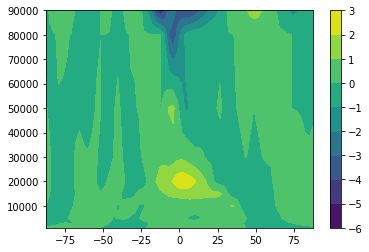

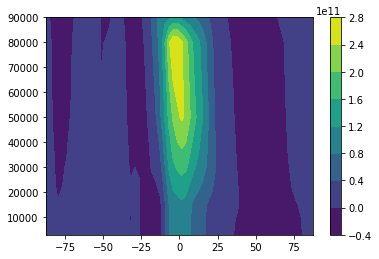

In [51]:
c = plt.contourf(lat, level_list_array, np.mean(var_dict['V_xBAR'][:], axis = 0))
plt.colorbar(c)
plt.show()
c = plt.contourf(lat, level_list_array[:-1], np.mean(psi(var_dict['V_xBAR'][:],level_list_array,lat), axis = 0))
plt.colorbar(c)
plt.show()



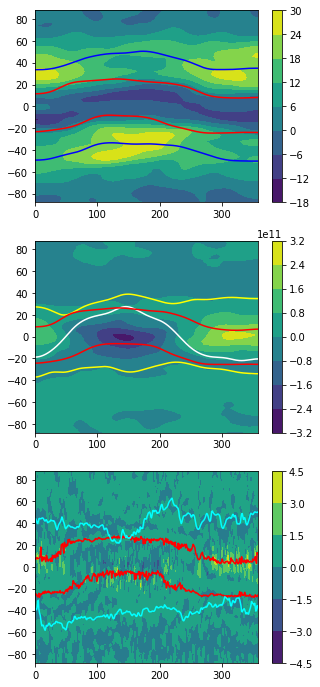

In [75]:
# Viz seasonal

len_t = 360
plt.figure(figsize=(5,12)) 

sigma = (0,15)
# upper
plt.subplot(3,1,1)
c1 = plt.contourf(np.arange(len_t), lat, ndimage.gaussian_filter(np.transpose(U_xBAR300), sigma=sigma, order=0))
plt.colorbar(c1)
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHC_sh[:,lev_i300]), sigma=sigma[1], order=0), "r") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHC_nh[:,lev_i300]), sigma=sigma[1], order=0), "r") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(lat_stj_sh), sigma=sigma[1], order=0),"b") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(lat_stj_nh), sigma=sigma[1], order=0),"b") 

# mid
plt.subplot(3,1,2)
c1 = plt.contourf(np.arange(len_t), lat, ndimage.gaussian_filter(np.transpose(psi500), sigma=sigma, order=0))
plt.colorbar(c1)
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(psi500_signchange_tropics), sigma=sigma[1], order=0),"w") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHCedge_sh), sigma=sigma[1], order=0),"yellow") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHC_sh[:,lev_i500]), sigma=sigma[1], order=0), "r") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHCedge_nh), sigma=sigma[1], order=0),"yellow") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHC_nh[:,lev_i500]), sigma=sigma[1], order=0), "r") 
# lower
plt.subplot(3,1,3)
c1 = plt.contourf(np.arange(len_t), lat, np.transpose(V_xBAR300))
plt.colorbar(c1)
plt.plot(np.arange(len_t), phiHC_sh[:,lev_i800], "r") 
plt.plot(np.arange(len_t), phiHC_nh[:,lev_i800], "r") 
plt.plot(np.arange(len_t), lat_u_midlat_sh,"cyan") 
plt.plot(np.arange(len_t), lat_u_midlat_nh,"cyan") 

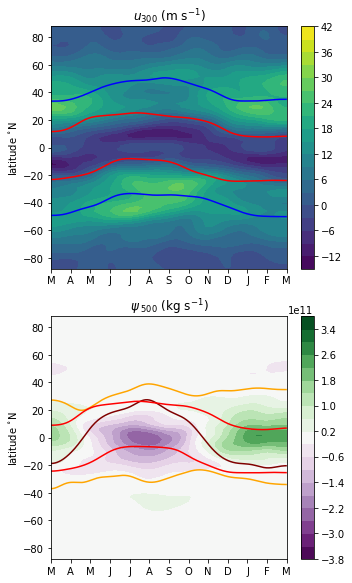

In [80]:
len_t = 360
plt.figure(figsize=(5,12)) 

sigma = (0,15)
# upper
plt.subplot(3,1,1)
c1 = plt.contourf(np.arange(len_t), lat, ndimage.gaussian_filter(np.transpose(U_xBAR300), sigma=sigma, order=0),np.arange(-15,45,3))
plt.colorbar(c1)
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHC_sh[:,lev_i300]), sigma=sigma[1], order=0), "r") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHC_nh[:,lev_i300]), sigma=sigma[1], order=0), "r") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(lat_stj_sh), sigma=sigma[1], order=0),"b") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(lat_stj_nh), sigma=sigma[1], order=0),"b") 
plt.xticks(np.arange(0,361,30), ['M','A','M','J','J','A','S','O','N','D','J','F','M'])
plt.ylabel(r"latitude $^{\circ}$N")
plt.title(r'$u_{300}$ (m s$^{-1}$)')
# mid
plt.subplot(3,1,2)
c1 = plt.contourf(np.arange(len_t), lat, ndimage.gaussian_filter(np.transpose(psi500), sigma=sigma, order=0),np.arange(-3.8e11,3.9e11,4e10), cmap='PRGn')
plt.colorbar(c1)
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(psi500_signchange_tropics), sigma=sigma[1], order=0),"maroon") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHCedge_sh), sigma=sigma[1], order=0),"orange") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHC_sh[:,lev_i500]), sigma=sigma[1], order=0), "r") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHCedge_nh), sigma=sigma[1], order=0),"orange") 
plt.plot(np.arange(len_t), ndimage.gaussian_filter(np.transpose(phiHC_nh[:,lev_i500]), sigma=sigma[1], order=0), "r") 
plt.ylabel(r"latitude $^{\circ}$N")
plt.title(r'$\psi_{\,\,500}$ (kg s$^{-1}$)')

plt.xticks(np.arange(0,361,30), ['M','A','M','J','J','A','S','O','N','D','J','F','M'])
plt.tight_layout()
plt.savefig('/groups/esm/lenka/synoptic_diffusivity/agu_plots/fms3_general_hc_stj.pdf')



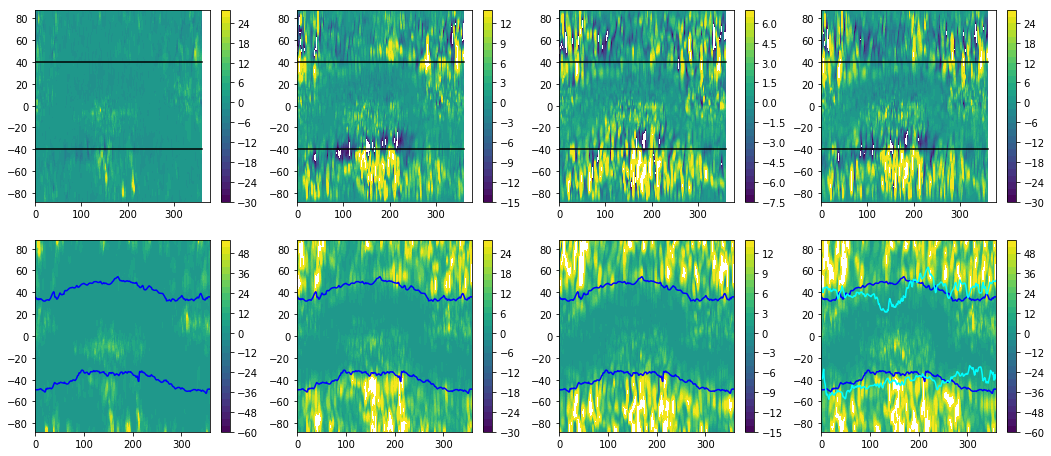

In [54]:
# Eddies
rng = np.arange(-150,150,10)/5.
plt.figure(figsize=(18,12)) 
plt.subplot(3,4,1)
c1 = plt.contourf(np.arange(len_t), lat, np.transpose(uPRvPR), rng)
plt.colorbar(c1)
#plt.plot(np.arange(len_t), lat_stj_sh,"b") 
#plt.plot(np.arange(len_t), lat_stj_nh,"b") 
plt.plot([0,360],[40,40],color="k")
plt.plot([0,360],[-40,-40],color="k")
plt.subplot(3,4,2)
c1 = plt.contourf(np.arange(len_t), lat, np.transpose(uPRvPR30),rng/2)
plt.colorbar(c1)
#plt.plot(np.arange(len_t), lat_stj_sh,"b") 
#plt.plot(np.arange(len_t), lat_stj_nh,"b") 
plt.plot([0,360],[40,40],color="k")
plt.plot([0,360],[-40,-40],color="k")
plt.subplot(3,4,3)
c1 = plt.contourf(np.arange(len_t), lat, np.transpose(uPRvPR60), rng/4)
plt.colorbar(c1)
# plt.plot(np.arange(len_t), lat_stj_sh,"b") 
# plt.plot(np.arange(len_t), lat_stj_nh,"b") 
plt.plot([0,360],[40,40],color="k")
plt.plot([0,360],[-40,-40],color="k")
plt.subplot(3,4,4)
c1 = plt.contourf(np.arange(len_t), lat, np.transpose(uSTvST), rng)
plt.colorbar(c1)
# plt.plot(np.arange(len_t), lat_stj_sh,"b") 
# plt.plot(np.arange(len_t), lat_stj_nh,"b") 
# plt.plot(np.arange(len_t), lat_u_midlat_sh,"cyan") 
# plt.plot(np.arange(len_t), lat_u_midlat_nh,"cyan") 
plt.plot([0,360],[40,40],color="k")
plt.plot([0,360],[-40,-40],color="k")
plt.subplot(3,4,5)
c1 = plt.contourf(np.arange(len_t), lat, np.transpose(vPRvPR), rng*2)
plt.colorbar(c1)
plt.plot(np.arange(len_t), lat_stj_sh,"b") 
plt.plot(np.arange(len_t), lat_stj_nh,"b") 
plt.subplot(3,4,6)
c1 = plt.contourf(np.arange(len_t), lat, np.transpose(vPRvPR30),rng)
plt.colorbar(c1)
plt.plot(np.arange(len_t), lat_stj_sh,"b") 
plt.plot(np.arange(len_t), lat_stj_nh,"b") 
plt.subplot(3,4,7)
c1 = plt.contourf(np.arange(len_t), lat, np.transpose(vPRvPR60), rng/2)
plt.colorbar(c1)
plt.plot(np.arange(len_t), lat_stj_sh,"b") 
plt.plot(np.arange(len_t), lat_stj_nh,"b") 
plt.subplot(3,4,8)
c1 = plt.contourf(np.arange(len_t), lat, np.transpose(vSTvST), rng*2)
plt.colorbar(c1)
plt.plot(np.arange(len_t), lat_stj_sh,"b") 
plt.plot(np.arange(len_t), lat_stj_nh,"b") 
plt.plot(np.arange(len_t), lat_u_midlat_sh,"cyan") 
plt.plot(np.arange(len_t), lat_u_midlat_nh,"cyan") 




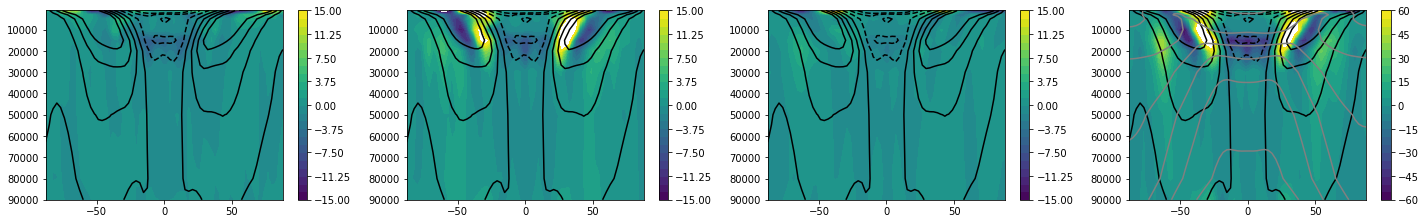

In [71]:
# Eddies vertical

for yr_i, yr in enumerate(yr_list):
    for mo_i, mo in enumerate(mo_list):
        if (yr_i == 0) or (yr_i ==len(yr_list)-1):
            break
        file_name = var_save_dir+'fms_m%s_HC_data_%00d_%00d.hdf5'%(m,yr_list[yr_i],mo_i+1)
        #file_name_slev = scratch+'era-5_olr_%00d_%00d.hdf5'%(yr,mo)
        var_dict = load_hdf5_file(file_name, var_dict_ )
        #var_dict_slev = load_hdf5_file(file_name_slev, var_dict_slev_ )
        lat = var_dict['lat'][:]
        if (mo_i == 0) & (yr_i ==1): 
            uSTvST_ = var_dict['uSTvST'][:,:,:]
            uPRvPR_ = var_dict['uPRvPR'][:,:,:][25:-25]
            uPRvPR30_ = var_dict['uPRvPR30'][:,:,:][15:-15]
            uPRvPR60_ = var_dict['uPRvPR60'][:,:,:]
            vSTvST_ = var_dict['vSTvST'][:,:,:]
            vPRvPR_ = var_dict['vPRvPR'][:,:,:][25:-25]
            vPRvPR30_ = var_dict['vPRvPR30'][:,:,:][15:-15]
            vPRvPR60_ = var_dict['vPRvPR60'][:,:,:]
            #vSTTST_ = var_dict['vSTTST'][:,:,:]
            #vPRTPR_ = var_dict['vPRTPR'][:,:,:]
            U_xBAR_ = var_dict['U_xBAR'][:,:,:]
            V_xBAR_ = var_dict['V_xBAR'][:,:,:]
            T_xBAR_ = var_dict['T_xBAR'][:,:,:]
            dudy_uPRvPR_ = var_dict['dudy_uPRvPR'][:,:,:][25:-25]
            dudy_uPRvPR30_ = var_dict['dudy_uPRvPR30'][:,:,:][15:-15]
            dudy_uPRvPR60_ = var_dict['dudy_uPRvPR60'][:,:,:]
        else:
            uSTvST_ = np.append(uSTvST_, var_dict['uSTvST'][:,:,:], axis = 0)  
            uPRvPR_ = np.append(uPRvPR_, var_dict['uPRvPR'][:,:,:][25:-25], axis = 0) 
            uPRvPR30_ = np.append(uPRvPR30_, var_dict['uPRvPR30'][:,:,:][15:-15], axis = 0) 
            uPRvPR60_ = np.append(uPRvPR60_, var_dict['uPRvPR60'][:,:,:], axis = 0) 
            vSTvST_ = np.append(vSTvST_, var_dict['vSTvST'][:,:,:], axis = 0)
            vPRvPR_ = np.append(vPRvPR_, var_dict['vPRvPR'][:,:,:][25:-25], axis = 0) 
            vPRvPR30_ = np.append(vPRvPR30_, var_dict['vPRvPR30'][:,:,:][15:-15], axis = 0) 
            vPRvPR60_ = np.append(vPRvPR60_, var_dict['vPRvPR60'][:,:,:], axis = 0) 
            #vSTTST_ = np.append(vSTTST_, var_dict['vSTTST'][:,:,:], axis = 0)
            #vPRTPR_ = np.append(vPRTPR_, var_dict['vPRTPR'][:,:,:], axis = 0)  
            U_xBAR_ = np.append(U_xBAR_, var_dict['U_xBAR'][:,:,:], axis = 0)  
            V_xBAR_ = np.append(V_xBAR_, var_dict['V_xBAR'][:,:,:], axis = 0) 
            T_xBAR_ = np.append(T_xBAR_, var_dict['T_xBAR'][:,:,:], axis = 0) 
            dudy_uPRvPR_ = np.append(dudy_uPRvPR_, var_dict['dudy_uPRvPR'][:,:,:][25:-25], axis = 0) 
            dudy_uPRvPR30_ = np.append(dudy_uPRvPR30_, var_dict['dudy_uPRvPR30'][:,:,:][15:-15], axis = 0)             
            dudy_uPRvPR60_ = np.append(dudy_uPRvPR60_, var_dict['dudy_uPRvPR60'][:,:,:], axis = 0) 

level_list_array = np.array([ 1000.,  3000.,  5000.,  10000.,  15000.,  20000.,  30000., 50000.,  80000., 90000.])[::-1] 
            
plt.figure(figsize=(20,6))
h = 0
i =360
plt.subplot(241)
f1 = plt.contourf(lat,level_list_array, np.mean(dudy_uPRvPR_[h:i,:,:],axis=0),np.arange(-120,130,10)/8.)
plt.colorbar(f1)
plt.contour(lat,level_list_array, np.mean((U_xBAR_)[h:i,:,:],axis=0),np.arange(-30,40,10),colors='k')
plt.gca().invert_yaxis()
plt.subplot(242)
f1 = plt.contourf(lat,level_list_array, np.mean(dudy_uPRvPR30_[h:i,:,:],axis=0),np.arange(-120,130,10)/8.)
plt.colorbar(f1)
plt.contour(lat,level_list_array, np.mean((U_xBAR_)[h:i,:,:],axis=0),np.arange(-30,40,10),colors='k')
plt.gca().invert_yaxis()
plt.subplot(243)
f1 = plt.contourf(lat,level_list_array, np.mean(dudy_uPRvPR60_[h:i,:,:],axis=0),np.arange(-120,130,10)/8.)
plt.colorbar(f1)
plt.contour(lat,level_list_array, np.mean((U_xBAR_)[h:i,:,:],axis=0),np.arange(-30,40,10),colors='k')
plt.gca().invert_yaxis()
plt.subplot(244)
f1 = plt.contourf(lat,level_list_array, np.mean((-np.gradient(U_xBAR_,axis=2)*uSTvST_)[h:i,:,:],axis=0),np.arange(-120,130,10)/2.0)
plt.contour(lat,level_list_array, np.mean((U_xBAR_)[h:i,:,:],axis=0),np.arange(-30,40,10),colors='k')
plt.contour(lat,level_list_array, np.mean((T_xBAR_)[h:i,:,:],axis=0),colors='0.5')
plt.colorbar(f1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

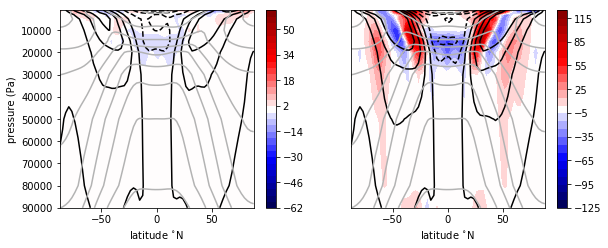

In [81]:
h = 0
i =360
plt.figure(figsize=(20,8))
plt.subplot(241)
f1 = plt.contourf(lat,level_list_array, np.mean(dudy_uPRvPR_[h:i,:,:],axis=0),np.arange(-62,64,4), cmap = 'seismic')
plt.colorbar(f1)
plt.contour(lat,level_list_array, np.mean((U_xBAR_)[h:i,:,:],axis=0),colors='k')
plt.contour(lat,level_list_array, np.mean((T_xBAR_)[h:i,:,:],axis=0),10,colors='0.7')
plt.gca().invert_yaxis()
plt.ylabel('pressure (Pa)')
plt.xlabel(r"latitude $^{\circ}$N")
plt.subplot(242)
f1 = plt.contourf(lat,level_list_array, np.mean((-np.gradient(U_xBAR_,axis=2)*uSTvST_)[h:i,:,:],axis=0),np.arange(-125,130,10), cmap = 'seismic')
plt.contour(lat,level_list_array, np.mean((U_xBAR_)[h:i,:,:],axis=0),np.arange(-30,40,10),colors='k')
plt.contour(lat,level_list_array, np.mean((T_xBAR_)[h:i,:,:],axis=0),10,colors='0.7')
plt.colorbar(f1)
plt.xlabel(r"latitude $^{\circ}$N")
plt.gca().invert_yaxis()
plt.yticks([])
plt.savefig('/groups/esm/lenka/synoptic_diffusivity/agu_plots/fms3_lat-pres_uv_stat.pdf')
plt.show()

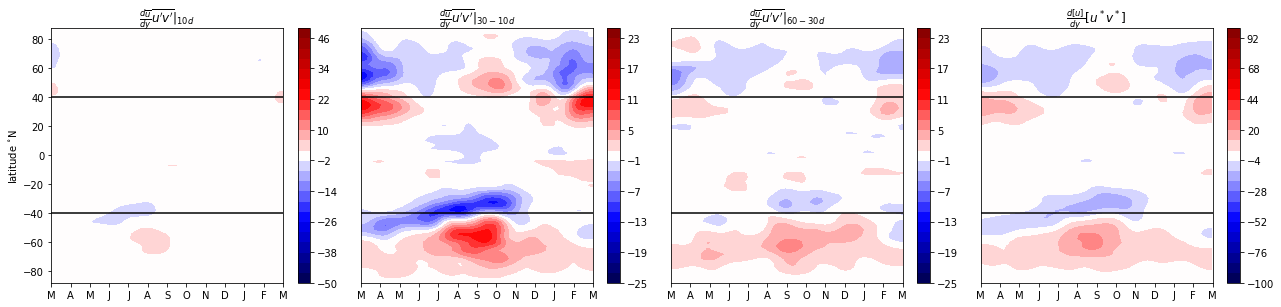

In [65]:
# AGU plots

import scipy.ndimage as ndimage

# Note the 0 sigma for the last axis, we don't wan't to blurr the color planes together!

ndays = 360

def avg_n_smooth(var, sigma):
    var_av = np.mean((var[:np.shape(var)[0]-int(np.shape(var)[0]%ndays),:]).reshape(int(np.floor(np.shape(var)[0]/ndays)), ndays, np.shape(var)[1]), axis=0)
    var_sm = ndimage.gaussian_filter(np.transpose(var_av), sigma=sigma, order=0)
    return var_sm

sigma = (0, 15)
rng = np.arange(-50,51,4)
plt.figure(figsize=(18,12)) 
plt.subplot(3,4,1)
plt.title(r"$\frac{d\overline{u}}{dy} \overline{u^{\prime}v^{\prime}}|_{10d}$")
c1 = plt.contourf(np.arange(ndays), lat, avg_n_smooth(uPRvPR_[:,lev_i300,:], sigma) , rng, cmap = "seismic")
plt.colorbar(c1)
#plt.plot(np.arange(len_t), lat_stj_sh,"b") 
#plt.plot(np.arange(len_t), lat_stj_nh,"b") 
plt.plot([0,360],[40,40],color="k")
plt.plot([0,360],[-40,-40],color="k")
plt.ylabel(r"latitude $^{\circ}$N")
plt.xlim([0,360])
plt.xticks(np.arange(0,370,30), ['M','A','M','J','J','A','S','O','N','D','J','F','M'])
plt.subplot(3,4,2)
plt.title(r"$\frac{d\overline{u}}{dy} \overline{u^{\prime}v^{\prime}}|_{30-10d}$")
c1 = plt.contourf(np.arange(ndays), lat, avg_n_smooth(uPRvPR30_[:,lev_i300,:], sigma),rng/2, cmap = "seismic")
plt.colorbar(c1)
#plt.plot(np.arange(len_t), lat_stj_sh,"b") 
#plt.plot(np.arange(len_t), lat_stj_nh,"b") 
plt.plot([0,360],[40,40],color="k")
plt.plot([0,360],[-40,-40],color="k")
plt.yticks([])
plt.xlim([0,360])
plt.xticks(np.arange(0,370,30), ['M','A','M','J','J','A','S','O','N','D','J','F','M'])
plt.subplot(3,4,3)
plt.title(r"$\frac{d\overline{u}}{dy} \overline{u^{\prime}v^{\prime}}|_{60-30d}$")
c1 = plt.contourf(np.arange(ndays), lat, avg_n_smooth(uPRvPR60_[:,lev_i300,:], sigma), rng/2, cmap = "seismic")
plt.colorbar(c1)
# plt.plot(np.arange(len_t), lat_stj_sh,"b") 
# plt.plot(np.arange(len_t), lat_stj_nh,"b") 
plt.plot([0,360],[40,40],color="k")
plt.plot([0,360],[-40,-40],color="k")
plt.yticks([])
plt.xlim([0,360])
plt.xticks(np.arange(0,370,30), ['M','A','M','J','J','A','S','O','N','D','J','F','M'])
plt.subplot(3,4,4)
plt.title(r"$\frac{d[u]}{dy} [u^*v^*]$")
c1 = plt.contourf(np.arange(ndays), lat, avg_n_smooth(uSTvST_[:,lev_i300,:], sigma), rng*2., cmap = "seismic")
plt.colorbar(c1)
# plt.plot(np.arange(len_t), lat_stj_sh,"b") 
# plt.plot(np.arange(len_t), lat_stj_nh,"b") 
# plt.plot(np.arange(len_t), lat_u_midlat_sh,"cyan") 
# plt.plot(np.arange(len_t), lat_u_midlat_nh,"cyan") 
plt.plot([0,360],[40,40],color="k")
plt.plot([0,360],[-40,-40],color="k")
#c1 = plt.contour(np.arange(ndays), lat, avg_n_smooth(uSTvST_[:,lev_i300,:], sigma), [0], colors = "k")
plt.yticks([])
plt.xlim([0,360])
plt.xticks(np.arange(0,370,30), ['M','A','M','J','J','A','S','O','N','D','J','F','M'])
plt.tight_layout()
plt.savefig('/groups/esm/lenka/synoptic_diffusivity/agu_plots/fms3_Lanczos_uv.pdf')





In [184]:
# Functions (export later): 
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.
    
    Refs:
    - https://scitools.org.uk/iris/docs/v1.2/examples/graphics/SOI_filtering.html
    - Duchon C. E. (1979) Lanczos Filtering in One and Two Dimensions.
    Journal of Applied Meteorology, Vol 18, pp 1016-1022.

    """
    order = ((window - 1) / 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([int(nwts)])
    n = int(nwts / 2)
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

def LanczosWeights(days,f):
    a=days/2.
    time=np.arange(-days/2,days/2+1,1)
    kernel=np.zeros((len(time)))
    test=np.zeros((len(time)))
    count=-1
    for k in time:
        count=count+1
        if (k >= -a) & (k<=a) ==True: 
            kernel[count] = (np.sin(2*np.pi*k*f)/(k*np.pi))*(np.sin(k*np.pi/a)/(k*np.pi/a))
    kernel[days/2]=2.*f
    return kernel


def LanczosWeightsW(days,f): # automatically uses the largest length of the filter
    ker=100000
    count=0
    add=2.
    for tries in np.arange(1,21):
        count=count+1
        k=LanczosWeights(days+add,f)
        if (np.sum(k[0:add/2.+1]**2))< 1e-30: # find ou how many days the filter can be widened by
            add=add+2
        else:
            ker=LanczosWeights(days+add-2,f)
            ker=ker[(add-2)/2:-(add-2)/2]   
    return ker

def print_ncinfo(dataset):
    for var in dataset.variables:
        var1 = dataset.variables[var]
        for name in var1.ncattrs():
            print var, '-->',name, '=', getattr(var1,name)
            
def runningmean(window1,var,noLanczos,f,ax_no,same_length): 
    """
    window1:Int = length of window (no time intervals) minus 1
    var:Array = variable
    noLanczos:Bool = Lanczos or equal weights
    f:Float = filtering frequency (1/window1)
    ax_no:Int = (time) axis index along which to filter
    same_length:Bool = whether zero-padded (?)
    """
    a=window1/2
    if noLanczos == True:
        weightsR= np.ones(int(window1)+1)/(window1+1.) # Normal filter (equal weights)
    else:
        weightsR=LanczosWeightsWIDE(window1,f)
        # e.g. for 10 day filter should get: [0, 0.01934108,0.06424144, 0.12517813,0.17866529,0.20000000,0.17866529,0.12517813,0.06424144,0.01934108,0]
    v1=convolve_along_axis(variable,a,weightsR/sum(weightsR),ax_no)
    if same_length == True:
        dummy_r = np.zeros((np.shape(v1)))        
        slc = [slice(None)] * len(v1.shape)
        slc[ax_no] = slice(0, a)
        dummy = dummy_r[slc]
        v1 = np.append(dummy,np.append(v1,dummy,axis=ax_no),axis=ax_no)
    return v1

def convolve_along_axis(variable,a,weightsR,ax_no):
    print datetime.datetime.today()
    
    a=int(a)
    v1=scipy.ndimage.filters.convolve1d(variable,weightsR, axis=ax_no,mode='reflect')
    print datetime.datetime.today()
    return v1

def test_filter(switch, var, varS):
    if switch ==True:
        plt.plot(np.arange(0,len(var)), var)
        plt.plot(np.arange(0,len(var)), varS)
        
def append_year_days(fn):
    ncdata =Dataset(fn%1,'r')
    print_ncinfo(ncdata)
    lat = ncdata.variables['lat'][:]
    lon = ncdata.variables['lon'][:]
    sig=ncdata.variables['sigma'][:]
    ncdata.close()
    v = np.zeros((360, len(sig), len(lat), len(lon)))
    u = np.zeros((360, len(sig), len(lat), len(lon)))
    for d_i, d in enumerate(np.arange(1,361)):
        ncdata = Dataset(fn%d,'r')
        v[d_i,:,:,:]=ncdata.variables['v'][:]
        u[d_i,:,:,:]=ncdata.variables['u'][:]
        ncdata.close()
    
    return lat, lon, sig, v, u

def gr_mer(var, latrad):
    """
    - calculate the meridional gradient using a centered difference
    
    Output:
        gr: (d var/d y) in var_units / m, with positive values meaning increasing var northward
    """
    dlat = np.abs(latrad[3]-latrad[4])
    gr = np.gradient(var,dlat,axis=-2) / 6371000. 
    sign = (latrad[4]-latrad[3]) / dlat
    gr = gr * sign
    return gr



In [4]:
lat

NameError: name 'lat' is not defined

In [10]:
print np.shape(v)

print sig

v[1,:,1,1]

(360, 12, 64, 128)
[0.6649279892444611 0.9546864628791809 -- -- -- -- -- -- -- -- -- --]


array([-7.20540015e-01, -2.64816437e+00,  9.96920997e+36,  9.96920997e+36,
        9.96920997e+36,  9.96920997e+36,  9.96920997e+36,  9.96920997e+36,
        9.96920997e+36,  9.96920997e+36,  9.96920997e+36,  9.96920997e+36])

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K


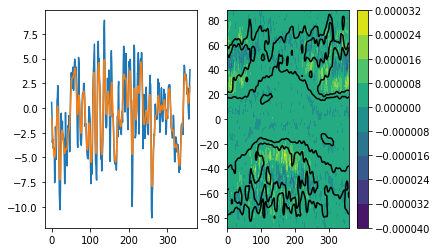

In [17]:
# test filtering
# Lanczos filter
window = 13. # the wider the better (before get -ve weights)
f = 1./10.

wgts11 = low_pass_weights(window, f)  

lat, lon, sig, v, u = append_year_days((data_dir+'/'+fname)%('42', '6', '1800','%s')  )

#gr_mer
uB = ndimage.filters.convolve1d(u[:,0,:,:], wgts11, axis=0,mode='reflect')
vB = ndimage.filters.convolve1d(v[:,0,:,:], wgts11, axis=0,mode='reflect')
uPvP = (v[:,0,:,:] - vB) * (u[:,0,:,:] - uB)
uPvPcon = gr_mer(uPvP, lat*np.pi/180.)

plt.figure()
plt.subplot(211)
test_filter(True, v[:,0,1,1], vB[:,1,1])
plt.subplot(212)
c = plt.contourf(np.arange(0,360),lat, np.transpose(np.mean(uPvPcon[:,:,:],axis=-1)))
plt.colorbar(c)
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB[:,:,:],axis=-1)), [5,10], colors = 'k')

In [56]:
# # filtering params
# nyq=0.5 * 1.
# f1 = 1./2.1 /nyq
# f2 = 1./6.5 /nyq
# f3 = 1./30 /nyq

# # calculate parameters for the filtering
# b, a = signal.butter(4, [f2,f1], btype='band')
# b_h, a_h = signal.butter(4, f2, btype='highpass')
# b_l, a_l = signal.butter(4, f2, btype='lowpass')
# b_h_hf, a_h_hf = signal.butter(4, f1, btype='highpass')
# b_l_hf, a_l_hf = signal.butter(4, f1, btype='lowpass')
# b_l_finalfilter, a_l_finalfilter = signal.butter(4, f3, btype='lowpass')

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

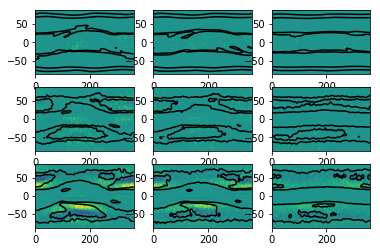

In [4]:
# plot the matrix

# Lanczos filter
window = 13. # the wider the better (before get -ve weights)
f = 1./10.

wgts11 = low_pass_weights(window, f)  

y = yr_list[0]
f = num_fourier_list[0]
o = depth_ocean_list[0]

plt.figure()
ct = 0
for f_i, f in enumerate(num_fourier_list[:]):
    for o_i, o in enumerate(depth_ocean_list[:]):
        ct += 1
        uPvPcon = 0
        uB_ = 0
        for y_i, y in enumerate(yr_list):
            lat, lon, sig, v, u = append_year_days( (data_dir+'/'+fname)%(f, o, y,'%s') )
            vB = ndimage.filters.convolve1d(v[:,0,:,:], wgts11, axis=0,mode='reflect')
            uB = ndimage.filters.convolve1d(u[:,0,:,:], wgts11, axis=0,mode='reflect')
            uB_ += uB / len(yr_list)
            uPvP = (v[:,0,:,:] - vB) * (u[:,0,:,:] - uB) 
            uPvPcon += gr_mer(uPvP, lat*np.pi/180.) / len(yr_list)           
            
            
        plt.subplot(len(num_fourier_list), len(depth_ocean_list), ct)
        plt.contourf(np.arange(0,360),lat, np.transpose(np.mean(uPvPcon[:,:,:],axis=-1)), np.arange(-15e-6,15e-6,1e-6))
        plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_[:,:,:],axis=-1)), [5, 10],colors = 'k')
        
        


lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

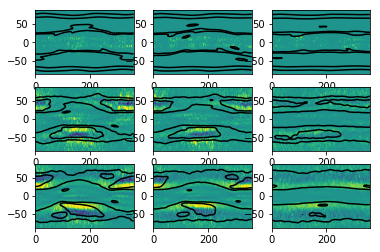

In [5]:
# plot the matrix

# Lanczos filter
window = 33. # the wider the better (before get -ve weights)
f = 1./30.

wgts11 = low_pass_weights(window, f)  

y = yr_list[0]
f = num_fourier_list[0]
o = depth_ocean_list[0]


plt.figure()
ct = 0
for f_i, f in enumerate(num_fourier_list[:]):
    for o_i, o in enumerate(depth_ocean_list[:]):
        ct += 1
        uPvPcon = 0
        uB_ = 0
        for y_i, y in enumerate(yr_list):
            lat, lon, sig, v, u = append_year_days( (data_dir+'/'+fname)%(f, o, y,'%s') )
            vB = ndimage.filters.convolve1d(v[:,0,:,:], wgts11, axis=0,mode='reflect')
            uB = ndimage.filters.convolve1d(u[:,0,:,:], wgts11, axis=0,mode='reflect')
            uB_ += uB / len(yr_list)
            uPvP = (v[:,0,:,:] - vB) * (u[:,0,:,:] - uB) 
            uPvPcon += gr_mer(uPvP, lat*np.pi/180.) / len(yr_list)           
            
            
        plt.subplot(len(num_fourier_list), len(depth_ocean_list), ct)
        plt.contourf(np.arange(0,360),lat, np.transpose(np.mean(uPvPcon[:,:,:],axis=-1)), np.arange(-15e-6,15e-6,1e-6))
        plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_[:,:,:],axis=-1)), [5, 10],colors = 'k')
        
        

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

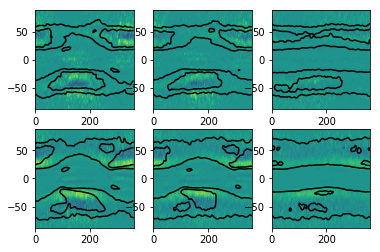

In [22]:
# plot the matrix

# Lanczos filter
window_hf = 9. # the wider the better (before get -ve weights)
f_hf = 1./6.
wgts11_hf = low_pass_weights(window_hf, f_hf)  

window_lf = 19. # the wider the better (before get -ve weights)
f_lf = 1./16.
wgts11_lf = low_pass_weights(window_lf, f_lf)  



y = yr_list[0]
f = num_fourier_list[0]
o = depth_ocean_list[0]


plt.figure()
ct = 0
for f_i, f in enumerate(num_fourier_list[:]):
    for o_i, o in enumerate(depth_ocean_list[:]):
        ct += 1
        uPvPcon = 0
        uB_ = 0
        for y_i, y in enumerate(yr_list):
            lat, lon, sig, v, u = append_year_days( (data_dir+'/'+fname)%(f, o, y,'%s') )
            vB_hf = ndimage.filters.convolve1d(v[:,0,:,:], wgts11_hf, axis=0,mode='reflect')
            uB_hf = ndimage.filters.convolve1d(u[:,0,:,:], wgts11_hf, axis=0,mode='reflect')

            vB_lf = ndimage.filters.convolve1d(v[:,0,:,:], wgts11_lf, axis=0,mode='reflect')
            uB_lf = ndimage.filters.convolve1d(u[:,0,:,:], wgts11_lf, axis=0,mode='reflect')
            uB_ += uB_lf / len(yr_list)
            
            uPvP = (v[:,0,:,:] - vB_lf) * (u[:,0,:,:] - uB_lf)  - (v[:,0,:,:] - vB_hf) * (u[:,0,:,:] - uB_hf)
            uPvPcon += gr_mer(uPvP, lat*np.pi/180.) / len(yr_list)           
            
            
        plt.subplot(len(num_fourier_list), len(depth_ocean_list), ct)
        plt.contourf(np.arange(0,360),lat, np.transpose(np.mean(uPvPcon[:,:,:],axis=-1)), np.arange(-15e-6,15e-6,1e-6))
        plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_[:,:,:],axis=-1)), [5, 10],colors = 'k')
        

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

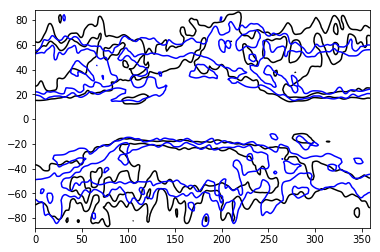

In [24]:
# test filtering
# Lanczos filter
window = 13. # the wider the better (before get -ve weights)
f = 1./10.

wgts11 = low_pass_weights(window, f)  

lat, lon, sig, v, u = append_year_days((data_dir+'/'+fname)%('42', '6', '5400','%s')  )

#gr_mer
uB = ndimage.filters.convolve1d(u[:,0,:,:], wgts11, axis=0,mode='reflect')
vB = ndimage.filters.convolve1d(v[:,0,:,:], wgts11, axis=0,mode='reflect')
uPvP = (v[:,0,:,:] - vB) * (u[:,0,:,:] - uB)
uPvPcon = gr_mer(uPvP, lat*np.pi/180.)

plt.figure()
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB[:,:,:],axis=-1)), [5,10], colors = 'k')


lat, lon, sig, v, u = append_year_days((data_dir+'/'+fname)%('3', '6', '5400','%s')  )

#gr_mer
uB = ndimage.filters.convolve1d(u[:,0,:,:], wgts11, axis=0,mode='reflect')
vB = ndimage.filters.convolve1d(v[:,0,:,:], wgts11, axis=0,mode='reflect')
uPvP = (v[:,0,:,:] - vB) * (u[:,0,:,:] - uB)
uPvPcon = gr_mer(uPvP, lat*np.pi/180.)

plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB[:,:,:],axis=-1)), [5,10], colors = 'b')




In [ ]:
# plot the matrix

# Lanczos filter
window = 13. # the wider the better (before get -ve weights)
f = 1./10.

wgts11 = low_pass_weights(window, f)  

y = yr_list[0]
f = num_fourier_list[0]
o = depth_ocean_list[0]

plt.figure()
uB_42 = 0
for y_i, y in enumerate(yr_list):
    lat, lon, sig, v, u = append_year_days( (data_dir+'/'+fname)%('42', '40', y,'%s') )
    uB = ndimage.filters.convolve1d(u[:,0,:,:], wgts11, axis=0,mode='reflect')
    uB_42 += uB / len(yr_list)  

uB_3 = 0
for y_i, y in enumerate(yr_list):
    lat, lon, sig, v, u = append_year_days( (data_dir+'/'+fname)%('3', '40', y,'%s') )
    uB = ndimage.filters.convolve1d(u[:,0,:,:], wgts11, axis=0,mode='reflect')
    uB_3 += uB / len(yr_list)

plt.subplot(111)
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_42[:,:,:],axis=-1)), [5, 10],colors = 'k')
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_3[:,:,:],axis=-1)), [5, 10],colors = 'b')
        



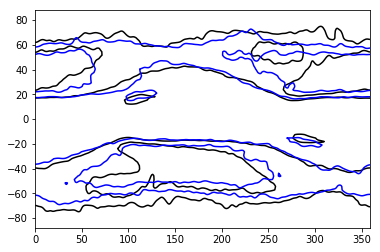

In [28]:
plt.subplot(111)
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_42[:,:,:],axis=-1)), [5, 10],colors = 'k')
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_3[:,:,:],axis=-1)), [5, 10],colors = 'b')



In [ ]:
# Meridional wind

# Lanczos filter
window = 13. # the wider the better (before get -ve weights)
f = 1./10.

wgts11 = low_pass_weights(window, f)  

y = yr_list[0]
f = num_fourier_list[0]
o = depth_ocean_list[0]

plt.figure()
uB_42 = 0
for y_i, y in enumerate(yr_list):
    lat, lon, sig, v, u = append_year_days( (data_dir+'/'+fname)%('42', '40', y,'%s') )
    uB = ndimage.filters.convolve1d(v[:,0,:,:], wgts11, axis=0,mode='reflect')
    uB_42 += uB / len(yr_list)  

uB_3 = 0
for y_i, y in enumerate(yr_list):
    lat, lon, sig, v, u = append_year_days( (data_dir+'/'+fname)%('3', '40', y,'%s') )
    uB = ndimage.filters.convolve1d(v[:,0,:,:], wgts11, axis=0,mode='reflect')
    uB_3 += uB / len(yr_list)



lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

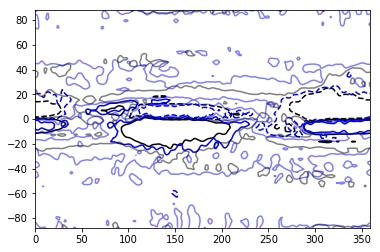

In [43]:
plt.subplot(111)
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_42[:,:,:],axis=-1)), [-0.2,0.2],colors = 'k')
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_3[:,:,:],axis=-1)), [-0.2,0.2],colors = 'b')
        
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_42[:,:,:],axis=-1)), [0, 10000],colors = 'k', alpha = 0.5)
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_3[:,:,:],axis=-1)), [0, 100000],colors = 'b', alpha = 0.5)




In [ ]:
plt.subplot(111)
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_42[:,:,:],axis=-1)), [-0.2,0.2],colors = 'k')
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_3[:,:,:],axis=-1)), [-0.2,0.2],colors = 'b')
        
# plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_42[:,:,:],axis=-1)), [0, 10000],colors = 'k', alpha = 0.5)
# plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_3[:,:,:],axis=-1)), [0, 100000],colors = 'b', alpha = 0.5)



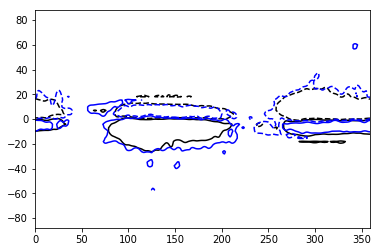

In [46]:
plt.subplot(111)
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_42[:,:,:],axis=-1)), [-0.2,0.2],colors = 'k')
plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_3[:,:,:],axis=-1)), [-0.2,0.2],colors = 'b')
        
# plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_42[:,:,:],axis=-1)), [0, 10000],colors = 'k', alpha = 0.5)
# plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB_3[:,:,:],axis=-1)), [0, 100000],colors = 'b', alpha = 0.5)


